In [2]:
# Import Modules
import gc
import os
import multiprocessing
import time
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import tensorflow as tf
from tqdm import tqdm

In [3]:
home_dir = "/kaggle/input/icecube-neutrinos-in-deep-ice/"
#test_meta_df = pd.read_parquet('/kaggle/input/meta-neutrinos/meta_'+str(353)).reset_index()
test_meta_df = pd.read_parquet('/kaggle/input/icecube-neutrinos-in-deep-ice/test_meta.parquet').reset_index()

In [4]:
# Directories and constants
home_dir = "/kaggle/input/icecube-neutrinos-in-deep-ice/"
#test_format = home_dir + 'train/batch_{batch_id:d}.parquet'
test_format = home_dir + 'test/batch_{batch_id:d}.parquet'
model_home = "/kaggle/input/lstmicecubesdata/"

# Model(s)
model_names = ["4347_MAE_1-02076_bin24_pp96_n6_batch2048_epoch29.h5",
               "4347_MAE_1-02039_bin24_pp96_n6_batch2048_epoch25.h5", 
               "4346_MAE_1-02020_bin24_pp96_n6_batch2048_epoch27.h5"]
model_weights = np.array([0.30, 
                          0.30,
                          0.40])

In [5]:
# Load Models
models = []
for model_name in model_names:
    print(f'\n========== Model File: {model_name}')
    
    # Load Model
    model_path = model_home + model_name
    model = tf.keras.models.load_model(model_path)
    models.append(model)      
    
    # Model summary
    model.summary()
    
# Get Model Parameters
pulse_count = model.inputs[0].shape[1]
feature_count = model.inputs[0].shape[2]
output_bins = model.layers[-1].weights[0].shape[-1]
bin_num = int(np.sqrt(output_bins))

# Model Parameter Summary
print("\n==== Model Parameters")
print(f"Bin Numbers: {bin_num}")
print(f"Maximum Pulse Count: {pulse_count}")
print(f"Features Count: {feature_count}")


========== Model File: 4347_MAE_1-02076_bin24_pp96_n6_batch2048_epoch29.h5
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 6)]           0         
                                                                 
 masking (Masking)           (None, 96, 6)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 96, 384)          230400    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 96, 384)          665856    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 384)              665856    
 nal)                                              

In [6]:
gc.collect()
# Load sensor_geometry
sensor_geometry_df = pd.read_csv(home_dir + "sensor_geometry.csv")

# Get Sensor Information
sensor_x = sensor_geometry_df.x
sensor_y = sensor_geometry_df.y
sensor_z = sensor_geometry_df.z

# Detector constants
c_const = 0.299792458  # speed of light [m/ns]

# Sensor Min / Max Coordinates
x_min = sensor_x.min()
x_max = sensor_x.max()
y_min = sensor_y.min()
y_max = sensor_y.max()
z_min = sensor_z.min()
z_max = sensor_z.max()

detector_length = np.sqrt((x_max - x_min)**2 + (y_max - y_min)**2 + (z_max - z_min)**2)
t_valid_length = detector_length / c_const

print(f"time valid length: {t_valid_length} ns")

time valid length: 6199.700247193777 ns


In [7]:
# Create Azimuth Edges
azimuth_edges = np.linspace(0, 2 * np.pi, bin_num + 1)
print(azimuth_edges)

# Create Zenith Edges
zenith_edges = []
zenith_edges.append(0)
for bin_idx in range(1, bin_num):
    zenith_edges.append(np.arccos(np.cos(zenith_edges[-1]) - 2 / (bin_num)))
zenith_edges.append(np.pi)
zenith_edges = np.array(zenith_edges)
print(zenith_edges)

[0.         0.26179939 0.52359878 0.78539816 1.04719755 1.30899694
 1.57079633 1.83259571 2.0943951  2.35619449 2.61799388 2.87979327
 3.14159265 3.40339204 3.66519143 3.92699082 4.1887902  4.45058959
 4.71238898 4.97418837 5.23598776 5.49778714 5.75958653 6.02138592
 6.28318531]
[0.         0.41113786 0.58568554 0.72273425 0.84106867 0.94796974
 1.04719755 1.1410209  1.23095942 1.31811607 1.40334825 1.48736624
 1.57079633 1.65422641 1.73824441 1.82347658 1.91063324 2.00057176
 2.0943951  2.19362291 2.30052398 2.41885841 2.55590711 2.73045479
 3.14159265]


In [8]:
angle_bin_zenith0 = np.tile(zenith_edges[:-1], bin_num)
angle_bin_zenith1 = np.tile(zenith_edges[1:], bin_num)
angle_bin_azimuth0 = np.repeat(azimuth_edges[:-1], bin_num)
angle_bin_azimuth1 = np.repeat(azimuth_edges[1:], bin_num)

angle_bin_area = (angle_bin_azimuth1 - angle_bin_azimuth0) * (np.cos(angle_bin_zenith0) - np.cos(angle_bin_zenith1))
angle_bin_vector_sum_x = (np.sin(angle_bin_azimuth1) - np.sin(angle_bin_azimuth0)) * ((angle_bin_zenith1 - angle_bin_zenith0) / 2 - (np.sin(2 * angle_bin_zenith1) - np.sin(2 * angle_bin_zenith0)) / 4)
angle_bin_vector_sum_y = (np.cos(angle_bin_azimuth0) - np.cos(angle_bin_azimuth1)) * ((angle_bin_zenith1 - angle_bin_zenith0) / 2 - (np.sin(2 * angle_bin_zenith1) - np.sin(2 * angle_bin_zenith0)) / 4)
angle_bin_vector_sum_z = (angle_bin_azimuth1 - angle_bin_azimuth0) * ((np.cos(2 * angle_bin_zenith0) - np.cos(2 * angle_bin_zenith1)) / 4)

angle_bin_vector_mean_x = angle_bin_vector_sum_x / angle_bin_area
angle_bin_vector_mean_y = angle_bin_vector_sum_y / angle_bin_area
angle_bin_vector_mean_z = angle_bin_vector_sum_z / angle_bin_area

angle_bin_vector = np.zeros((1, bin_num * bin_num, 3))
angle_bin_vector[:, :, 0] = angle_bin_vector_mean_x
angle_bin_vector[:, :, 1] = angle_bin_vector_mean_y
angle_bin_vector[:, :, 2] = angle_bin_vector_mean_z

angle_bin_vector_unit = angle_bin_vector[0].copy()
angle_bin_vector_unit /= np.sqrt((angle_bin_vector_unit**2).sum(axis=1).reshape((-1, 1)))

In [9]:
# Placeholder
open_batch_dict = dict()

# Read single event from batch_meta_df
def read_event(event_idx, batch_meta_df, pulse_count):
    # Read metadata
    batch_id, first_pulse_index, last_pulse_index = batch_meta_df.iloc[event_idx][["batch_id", "first_pulse_index", "last_pulse_index"]].astype("int")

    # close past batch df
    if batch_id - 1 in open_batch_dict.keys():
        del open_batch_dict[batch_id - 1]

    # open current batch df
    if batch_id not in open_batch_dict.keys():
        open_batch_dict.update({batch_id: pd.read_parquet(test_format.format(batch_id=batch_id))})
    
    batch_df = open_batch_dict[batch_id]
    
    # Read event
    event_feature = batch_df[first_pulse_index:last_pulse_index + 1]
    sensor_id = event_feature.sensor_id
    
    # Merge features into single structured array
    dtype = [("time", "float16"),
             ("charge", "float16"),
             ("auxiliary", "float16"),
             ("x", "float16"),
             ("y", "float16"),
             ("z", "float16"),
             ("rank", "short")]    
    
    # Create event_x
    event_x = np.zeros(last_pulse_index - first_pulse_index + 1, dtype)
    event_x["time"] = event_feature.time.values - event_feature.time.min()
    event_x["charge"] = event_feature.charge.values
    event_x["auxiliary"] = event_feature.auxiliary.values
    event_x["x"] = sensor_geometry_df.x[sensor_id].values
    event_x["y"] = sensor_geometry_df.y[sensor_id].values
    event_x["z"] = sensor_geometry_df.z[sensor_id].values

    # For long event, pick-up
    if len(event_x) > pulse_count:
        # Find valid time window
        t_peak = event_x["time"][event_x["charge"].argmax()]
        t_valid_min = t_peak - t_valid_length
        t_valid_max = t_peak + t_valid_length
        t_valid = (event_x["time"] > t_valid_min) * (event_x["time"] < t_valid_max)

        # Rank
        event_x["rank"] = 2 * (1 - event_x["auxiliary"]) + (t_valid)

        # Sort by Rank and Charge (important goes to backward)
        event_x = np.sort(event_x, order = ["rank", "charge"])

        # pick-up from backward
        event_x = event_x[-pulse_count:]

        # Sort events by time 
        event_x = np.sort(event_x, order = "time")

    return event_idx, len(event_x), event_x

In [10]:
# Read Test Meta data
#test_meta_df = (pq.read_table(home_dir + 'test_meta.parquet').to_pandas())
#test_meta_df = pd.read_parquet(home_dir + 'train_meta.parquet')[0:100]

gc.collect()

batch_counts = test_meta_df.batch_id.value_counts().sort_index()

batch_max_index = batch_counts.cumsum()
batch_max_index[test_meta_df.batch_id.min() - 1] = 0
batch_max_index = batch_max_index.sort_index()

# Support Function
def test_meta_df_spliter(batch_id):
    return test_meta_df.loc[batch_max_index[batch_id - 1]:batch_max_index[batch_id] - 1]

In [12]:
# Get Batch IDs
test_batch_ids = test_meta_df.batch_id.unique()

# Submission Placeholders
test_event_id = []
test_azimuth = []
test_zenith = []

pred_raw_0=[]

# Batch Loop
for batch_id in test_batch_ids:
    # Batch Meta DF
    batch_meta_df = test_meta_df_spliter(batch_id)

    # Set Pulses
    test_x = np.zeros((len(batch_meta_df), pulse_count, feature_count), dtype = "float16")    
    test_x[:, :, 2] = -1    

    # Read Event Data
    def read_event_local(event_idx):
        return read_event(event_idx, batch_meta_df, pulse_count)
    
    # Multiprocess Events
    iterator = range(len(batch_meta_df))
    with multiprocessing.Pool() as pool:
        for event_idx, pulsecount, event_x in pool.map(read_event_local, iterator):
            # Features
            test_x[event_idx, :pulsecount, 0] = event_x["time"]
            test_x[event_idx, :pulsecount, 1] = event_x["charge"]
            test_x[event_idx, :pulsecount, 2] = event_x["auxiliary"]
            test_x[event_idx, :pulsecount, 3] = event_x["x"]
            test_x[event_idx, :pulsecount, 4] = event_x["y"]
            test_x[event_idx, :pulsecount, 5] = event_x["z"]
    
    del batch_meta_df
    
    # Normalize
    test_x[:, :, 0] /= 1000  # time
    test_x[:, :, 1] /= 300  # charge
    test_x[:, :, 3:] /= 600  # space
    
    
    pred_mod1=models[0].predict(test_x, verbose=0)
    gc.collect()
    pred_mod2=models[1].predict(test_x, verbose=0)
    gc.collect()
    pred_mod3=models[2].predict(test_x, verbose=0)
    gc.collect()
    
    pred_mod=0.3*pred_mod1+0.3*pred_mod2+0.4*pred_mod3

    

In [ ]:
import plotly.express as px
import plotly.offline as offline
offline.init_notebook_mode(connected=True)

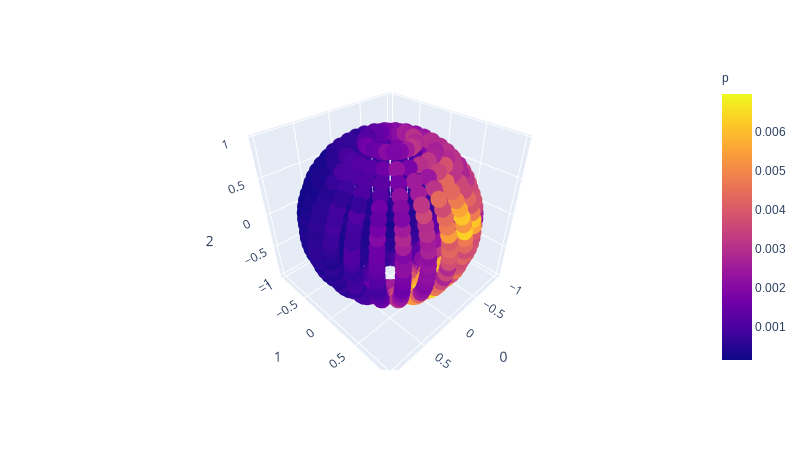

In [14]:
df=pd.DataFrame(angle_bin_vector[0])
df['p']=pd.Series(pred_mod[0].tolist())
df['s']=4

fig = px.scatter_3d(df, x=0, y=1, z=2,color="p")
fig.update_traces(marker_size=10)
fig.show()

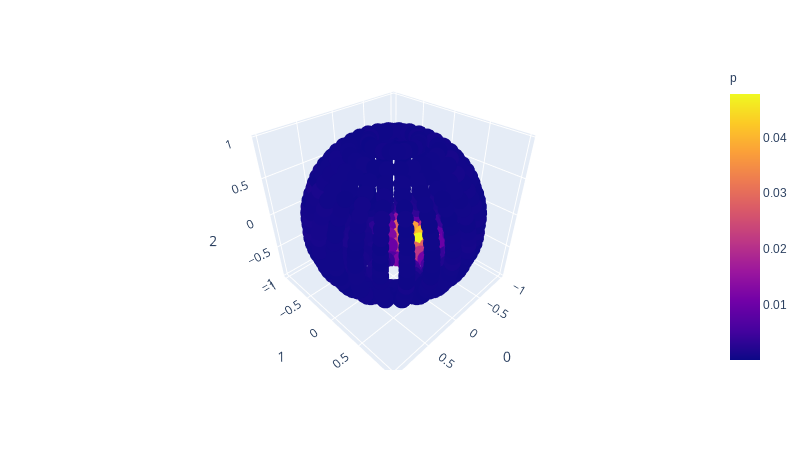

In [15]:
df=pd.DataFrame(angle_bin_vector[0])
df['p']=pd.Series(pred_mod[1].tolist())
df['s']=4

fig = px.scatter_3d(df, x=0, y=1, z=2,color="p")
fig.update_traces(marker_size=10)
fig.show()

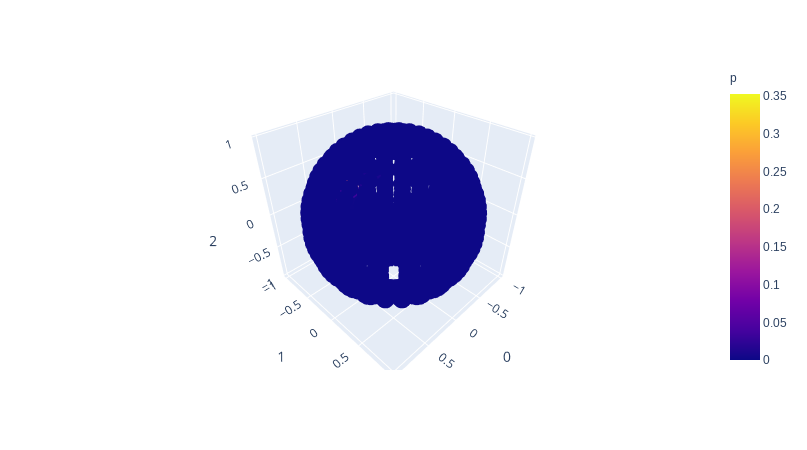

In [13]:


df=pd.DataFrame(angle_bin_vector[0])
df['p']=pd.Series(pred_mod[2].tolist())
df['s']=4

fig = px.scatter_3d(df, x=0, y=1, z=2,color="p")
fig.update_traces(marker_size=10)
fig.show()
